# t-SNE(法二)

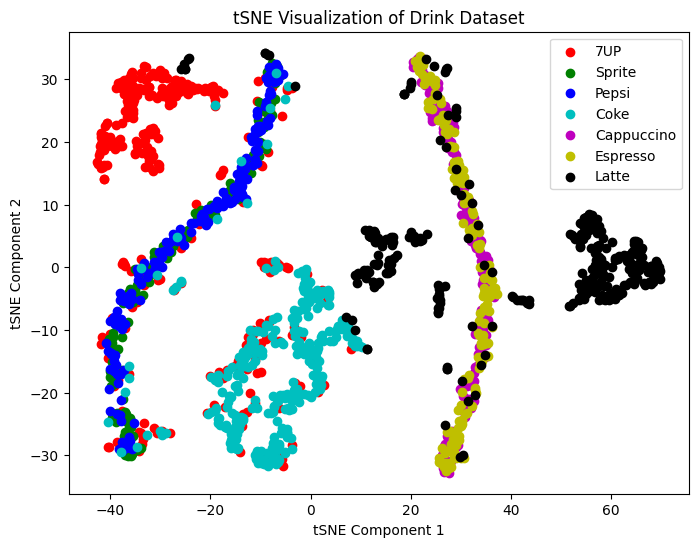

In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 定義資料特徵
drinks = ['7UP', 'Sprite', 'Pepsi', 'Coke', 'Cappuccino', 'Espresso', 'Latte']
ranks = [7, 6, 5, 4, 3, 2, 1]
amounts_mean = [100, 200, 200, 400, 800, 800, 900]
amounts_std = [200, 10, 10, 100, 10, 10, 400]
quantities_min = [500, 500, 500, 500, 1, 1, 1]
quantities_max = [1000, 1000, 1000, 1000, 500, 500, 500]
counts = [300, 150, 150, 300, 150, 150, 300]

# 產生資料
data = []
for i in range(len(drinks)):
    amount = np.random.normal(amounts_mean[i], amounts_std[i], counts[i])
    quantity = np.random.randint(quantities_min[i], quantities_max[i], counts[i])
    drink = [drinks[i]] * counts[i]
    rank = [ranks[i]] * counts[i]
    class_label = [chr(ord('A') + i)] * counts[i]
    df = pd.DataFrame({'Drink': drink, 'Rank': rank, 'Amount': amount, 'Quantity': quantity, 'Class': class_label})
    data.append(df)
    
df = pd.concat(data, ignore_index=True)

# 將特徵欄位進行標準化（可選）
#df[['Rank', 'Amount', 'Quantity']] = (df[['Rank', 'Amount', 'Quantity']] - df[['Rank', 'Amount', 'Quantity']].mean()) / df[['Rank', 'Amount', 'Quantity']].std()

# 執行 tSNE 降維
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df[['Rank', 'Amount', 'Quantity']])

# 繪製 tSNE 結果
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for i, class_label in enumerate(df['Drink'].unique()):
    indices = df['Drink'] == class_label
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], c=colors[i], label=class_label)
plt.legend()
plt.title('tSNE Visualization of Drink Dataset')
plt.xlabel('tSNE Component 1')
plt.ylabel('tSNE Component 2')
plt.show()


In [2]:
df

,Drink,Rank,Amount,Quantity,Class
0,7UP,7,222.586596,751,A
1,7UP,7,107.798801,925,A
2,7UP,7,-197.760299,593,A
3,7UP,7,-62.923881,880,A
4,7UP,7,-266.251102,861,A
...,...,...,...,...,...
1495,Latte,1,985.483881,61,G
1496,Latte,1,721.085079,205,G
1497,Latte,1,1249.541533,243,G
1498,Latte,1,543.809990,430,G


# 1-of-K 與 屬性值相似度

In [6]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder

# 將名目型屬性轉換為數值型變數（1-of-K 編碼）
encoded_data = pd.get_dummies(df[['Drink']])
data_binary = encoded_data.astype(int)

# 計算屬性值之間的相似度矩陣
similarity_matrix = encoded_data.copy()
similarity_matrix[encoded_data == 1] = 1
similarity_matrix[encoded_data == 0] = 2

# 使用 t-SNE 降維（1-of-K 編碼方法）
tsne = TSNE(n_components=2, perplexity=30, random_state=42, verbose=1)
tsne_encoded = tsne.fit_transform(data_binary)

# 使用 t-SNE 降維（考慮屬性值相似度方法）
tsne_similarity = TSNE(n_components=2, perplexity=20, random_state=42, verbose=1)
tsne_similarity_encoded = tsne_similarity.fit_transform(similarity_matrix)

# 將 Class 欄位進行數值標籤轉換
class_labels = df['Class']
label_encoder = LabelEncoder()
class_labels_encoded = label_encoder.fit_transform(class_labels)

# 繪製 t-SNE 降維結果（1-of-K 編碼方法）
fig1 = px.scatter(x=tsne_encoded[:, 0], y=tsne_encoded[:, 1], color=df['Drink'])
fig1.update_layout(title='t-SNE Visualization (1-of-K Encoding)',
                   xaxis_title='Component 1', yaxis_title='Component 2')
fig1.show()

# 繪製 t-SNE 降維結果（考慮屬性值相似度方法）
fig2 = px.scatter(x=tsne_similarity_encoded[:, 0], y=tsne_similarity_encoded[:, 1], color=df['Drink'])
fig2.update_layout(title='t-SNE Visualization (Similarity Matrix)',
                   xaxis_title='Component 1', yaxis_title='Component 2')
fig2.show()

# 使用 Linked Brushes 技術取得圈選資料群集
scatter_data = go.Scatter(x=tsne_similarity_encoded[:, 0], y=tsne_similarity_encoded[:, 1],
                          mode='markers', text=df['Drink'], marker=dict(color=class_labels_encoded))

fig3 = go.Figure(data=[scatter_data])

# 設定圈選資料的回調函式
callback = """
function(eventData) {
  var selectedPoints = eventData.points;
  var selectedData = [];
  for (var i = 0; i < selectedPoints.length; i++) {
    selectedData.push(selectedPoints[i].text);
  }
  console.log(selectedData);
}
"""

fig3.update_layout(title='t-SNE Visualization with Linked Brushes')
fig3.update_traces(selectedpoints={'marker': {'color': df['Drink']}})
fig3.update_layout(dragmode='select')
fig3.update_layout(clickmode='event+select')
fig3.update_layout(
    xaxis=dict(title='Component 1'),
    yaxis=dict(title='Component 2'),
    hovermode='closest',
    updatemenus=[dict(type="buttons", buttons=[dict(label="Reset", method="relayout", args=["dragmode", "select"])])],
    showlegend=False
)
fig3.add_annotation(
    text="Select Data Points",
    xref="paper",
    yref="paper",
    x=0.5,
    y=1.05,
    showarrow=False,
    font=dict(size=14)
)
#fig3.add_event_handler('selected', callback)
#fig3.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.002s...
[t-SNE] Computed neighbors for 1500 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 11.447535
[t-SNE] KL divergence after 1000 iterations: -7.211895
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.002s...
[t-SNE] Computed neighbors for 1500 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 20.514965
[t-SNE] KL divergence after 1000 iterations: -5.098577


In [4]:
similarity_matrix

,Drink_7UP,Drink_Cappuccino,Drink_Coke,Drink_Espresso,Drink_Latte,Drink_Pepsi,Drink_Sprite
0,1,2,2,2,2,2,2
1,1,2,2,2,2,2,2
2,1,2,2,2,2,2,2
3,1,2,2,2,2,2,2
4,1,2,2,2,2,2,2
...,...,...,...,...,...,...,...
1495,2,2,2,2,1,2,2
1496,2,2,2,2,1,2,2
1497,2,2,2,2,1,2,2
1498,2,2,2,2,1,2,2


In [5]:
tsne_similarity_encoded.shape

(1500, 2)

## Word2Vec測試(請忽略)

In [251]:
#pip install -U gensim

     ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
     ---------------------------------------- 0.2/24.0 MB 3.7 MB/s eta 0:00:07
     - -------------------------------------- 0.6/24.0 MB 6.3 MB/s eta 0:00:04
     -- ------------------------------------- 1.5/24.0 MB 10.5 MB/s eta 0:00:03
     --- ------------------------------------ 2.1/24.0 MB 13.3 MB/s eta 0:00:02
     --- ------------------------------------ 2.1/24.0 MB 13.3 MB/s eta 0:00:02
     --- ------------------------------------ 2.1/24.0 MB 13.3 MB/s eta 0:00:02
     --- ------------------------------------ 2.1/24.0 MB 13.3 MB/s eta 0:00:02
     ---- ----------------------------------- 2.6/24.0 MB 7.1 MB/s eta 0:00:04
     ------ --------------------------------- 4.2/24.0 MB 10.3 MB/s eta 0:00:02
     ------ --------------------------------- 4.2/24.0 MB 10.3 MB/s eta 0:00:02
     ------ --------------------------------- 4.2/24.0 MB 10.3 MB/s eta 0:00:02
     ------ --------------------------------- 4.2/2

In [254]:
from gensim.models import Word2Vec
import pandas as pd
# 將名目型屬性轉換為文本資料
sentences = df['Drink'].apply(lambda x: x.split()).tolist()

# 使用 Word2Vec 訓練詞向量模型
model = Word2Vec(sentences, min_count=1, vector_size=100)

# 計算名目型屬性值之間的距離
distance = model.wv.distance('7UP', 'Sprite')

print(f"Distance between '7UP' and 'Sprite': {distance}")

Distance between '7UP' and 'Sprite': 0.854049414396286
